## 0. Goal 
Check the k-NN output from UMAP, to see if it makes sense. <br>
Compare between default approximation and external exact method

In [2]:
import os, sys, importlib, librosa, glob, h5py, tqdm, pickle
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from joblib import Parallel, delayed
import random
import umap, hdbscan
from collections import Counter, OrderedDict
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from skimage import transform
import gc
import colorsys
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

plt.rcParams['pdf.fonttype'] = 42 

In [3]:
# import my utility script
cluster_script_path = '/home/zz367/ProjectsU/EphysMONAO/Jupyter/MatlabCodes/ZZ_callClustering/'
sys.path.insert(1, cluster_script_path)
import vae_goffinet, hopkins
importlib.reload(vae_goffinet)

<module 'vae_goffinet' from '/home/zz367/ProjectsU/EphysMONAO/Jupyter/MatlabCodes/ZZ_callClustering/vae_goffinet.py'>

In [4]:
# create a custom colormap for spectrogram
jet = plt.get_cmap('jet', 255)
# Extract jet colors and prepend black at the beginning
jet_colors = jet(np.linspace(0, 1, 255))
custom_colors = np.vstack([[0, 0, 0, 1], jet_colors])  # Black for 0, then jet
custom_cmap = ListedColormap(custom_colors)

## 1. Inputs

In [5]:
fd_z4 = '/mnt/z4'
fd_data = os.path.join(fd_z4, 'zz367', 'EphysMONAO', 'Analyzed', 'vaeWav')
birdID = 'pair5RigCCU29'
# color limits when calculating spectrograms, depending on the audio amplitude, may differ between birds
clims = [1.5,7]
# what syllable pairs to analyze
v_all = ['v4', 'v5']
# what spectogram datasets to use
spec_suffix = 'Spectrogram1'
spec_run = 'spec_goffinet_traj_256_236'
# what VAE run to use
vae_suffix = 'VAE1'
vae_run = 'traj_chop_32_2_32'
fd_vae = os.path.join(fd_data, birdID, 'Traj', vae_suffix, vae_run)
# where the VAE latents results are saved
apply_suffix = 'applySyl1'
apply_run = f'latent.{vae_run}'
fd_latent = os.path.join(fd_data, birdID, 'Traj', apply_suffix, apply_run)
print(fd_latent)

/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5RigCCU29/Traj/applySyl1/latent.traj_chop_32_2_32


In [6]:
# where to save results
fd_save = os.path.join(fd_data, birdID, 'Traj', apply_suffix, 'paramSearch1')
if not os.path.exists(fd_save):
    os.makedirs(fd_save)
print(fd_save)

/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5RigCCU29/Traj/applySyl1/paramSearch1


In [7]:
# load the latent
syl_str = ''.join(v_all)
fn_latent = os.path.join(fd_save, f'{syl_str}_latent_comb.csv')
latent_comb = np.loadtxt(fn_latent)
fn_info = os.path.join(fd_save, f'{syl_str}_info_comb.csv')
info_comb = pd.read_csv(fn_info, index_col=0)
print(latent_comb.shape, info_comb.shape)

(61152, 32) (61152, 21)


## 2. Run the UMAP

In [10]:
nn = 25
md = 0
mt = 'euclidean'
vs = 0
ke = 0

/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5RigCCU29/Traj/applySyl1/paramSearch1/v4v5.nn25_md0_euclidean_vs0_ke0
UMAP(min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Thu Jul 24 12:40:58 2025 Construct fuzzy simplicial set
Thu Jul 24 12:40:58 2025 Finding Nearest Neighbors
Thu Jul 24 12:40:58 2025 Building RP forest with 17 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Thu Jul 24 12:41:01 2025 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations
Thu Jul 24 12:41:12 2025 Finished Nearest Neighbor Search
Thu Jul 24 12:41:13 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Thu Jul 24 12:41:52 2025 Finished embedding


Text(0, 0.5, 'UMAP axis 2')

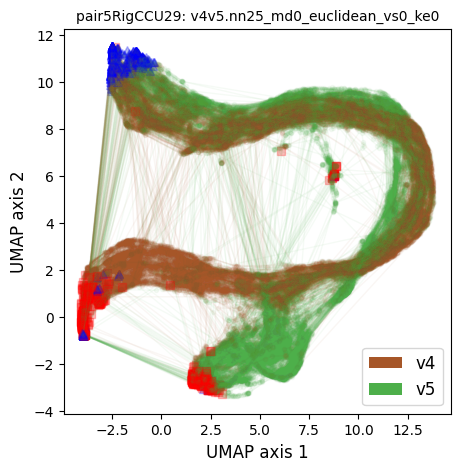

In [11]:
# set a run name 
run_name = f'{syl_str}.nn{nn}_md{md}_{mt}_vs{vs}_ke{ke}'
fd_save_run = os.path.join(fd_save, run_name)
if not os.path.exists(fd_save_run):
    os.makedirs(fd_save_run)
print(fd_save_run)

d = latent_comb.copy()

# standarize vae latents if specified
if vs==1:
    scaler = StandardScaler(with_mean=True, with_std=True)
    d = scaler.fit_transform(d)     # same shape as d

# run UMAP 
if ke==1:
    # first calculate the exact k-NN
    nbrs = NearestNeighbors(n_neighbors=nn, algorithm='brute', metric=mt, n_jobs=-1).fit(d)
    distances, indices = nbrs.kneighbors(d, return_distance=True)
    indices   = indices.astype(np.int64,  copy=False)
    distances = distances.astype(np.float32, copy=False)
    umap_model = umap.UMAP(n_neighbors=nn, n_components=2, min_dist=md, metric=mt, random_state=1118, low_memory=False, verbose=True, precomputed_knn=(indices, distances))
else:
    umap_model = umap.UMAP(n_neighbors=nn, n_components=2, min_dist=md, metric=mt, random_state=1118, verbose=True)
res = umap_model.fit_transform(d)

# put results in a master dataframe
embed = info_comb.copy()
for ii in range(d.shape[1]):
    embed[f'vae{ii}'] = d[:,ii]
for jj in range(res.shape[1]):
    embed[f'umap{jj+1}'] = res[:,jj]

# save the embedding
# fn_embed = os.path.join(fd_save_run, f'{birdID}.{run_name}.embedding.csv')
# embed.to_csv(fn_embed)

#### plot results, different color for different call subtypes
col_full = ['#a65628','#4daf4a','#984ea3','#e41a1c','#ff7f00','#f781bf','#377eb8','#737373']
col_dict = OrderedDict(zip(v_all, col_full[0:len(v_all)]))
# get the syl id
syl_comb = list(set(info_comb['syl_id']))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[5, 5])
for si in range(len(syl_comb)):
    ss = syl_comb[si]
    embed_s = embed[embed['syl_id']==ss]
    embed_s.index = range(embed_s.shape[0])
    x = np.array(embed_s['umap1'])
    y = np.array(embed_s['umap2'])
    v = embed_s['call_subtype'][0]
    ax.plot(x, y,  marker='o', linestyle='-', color=col_dict[v], markersize=3, linewidth=1, alpha=0.05)
    # mark the start with triangle, and end with square
    ax.plot(x[0], y[0], marker='^', markersize=6, color='blue', alpha=0.25)
    ax.plot(x[-1], y[-1], marker='s', markersize=6, color='red', alpha=0.25)
# add legend
legends = [Patch(facecolor=col_dict[name], label=name) for name in col_dict.keys()]
ax.legend(handles=legends, loc='lower right', fontsize=12)
ax.set_title(f'{birdID}: {run_name}', fontsize=10)
ax.set_xlabel('UMAP axis 1', fontsize=12)
ax.set_ylabel('UMAP axis 2', fontsize=12)

## 3. Check the KNN 

In [14]:
# get the KNN from UMAP output
knn_idx = umap_model._knn_indices
knn_dist = umap_model._knn_dists
print(knn_idx.shape, knn_dist.shape)

(61152, 25) (61152, 25)


In [59]:
# get the KNN using exact method
nbrs = NearestNeighbors(n_neighbors=nn, algorithm='brute', metric=mt, n_jobs=-1).fit(latent_comb)
exact_dist, exact_idx = nbrs.kneighbors(latent_comb, return_distance=True)
print(exact_idx.shape)

(61152, 25)


In [16]:
# focus on the jumping point
i_jump = 3808
i_to = 3867
chk_idx = [3806,3807,3808,3809,3910,3867]
info_comb.iloc[chk_idx,:]

,ri,i_i,i_s,i_e,index,fn_wav,s_idx,istart,iend,label,...,spec_t,i_start,i_end,zero_start,zero_end,rel_ori,hdbscan_cluster,hdbscan_prob,call_subtype,syl_id
3806,40183,24,66,98,40183,/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5...,16,123600,127440,v,...,[0. 0.001 0.002 0.003 0.004 0.005 0.006 0.0...,122600,128440,0,0,1000,4.0,1.0,v4,/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5...
3807,40183,25,68,100,40183,/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5...,16,123600,127440,v,...,[0. 0.001 0.002 0.003 0.004 0.005 0.006 0.0...,122600,128440,0,0,1000,4.0,1.0,v4,/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5...
3808,40183,26,70,102,40183,/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5...,16,123600,127440,v,...,[0. 0.001 0.002 0.003 0.004 0.005 0.006 0.0...,122600,128440,0,0,1000,4.0,1.0,v4,/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5...
3809,40183,27,72,104,40183,/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5...,16,123600,127440,v,...,[0. 0.001 0.002 0.003 0.004 0.005 0.006 0.0...,122600,128440,0,0,1000,4.0,1.0,v4,/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5...
3910,41571,15,48,80,41571,/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5...,26,144300,147760,v,...,[0. 0.001 0.002 0.003 0.004 0.005 0.006 0.0...,143300,148760,0,0,1000,4.0,1.0,v4,/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5...
3867,40183,85,188,220,40183,/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5...,16,123600,127440,v,...,[0. 0.001 0.002 0.003 0.004 0.005 0.006 0.0...,122600,128440,0,0,1000,4.0,1.0,v4,/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5...


In [18]:
knn_idx[chk_idx,:]

array([[ 3806,  3807,  3805,  3808, 38687,  1435, 35023, 38515, 44367,
        35021, 42607,  3809, 42269, 38514,  4862,  1436, 35022, 38516,
         4860, 19316, 44368,  4861, 33450,  1434, 42606],
       [ 3807,  3806,  3808,  3805,  3809,  1435,  1434, 38687,  1436,
        33450,  3119,  4862, 35023,  3430, 38515,  3810,  4861, 38514,
        12428,  3431, 42607,  3118, 19317,  2707,  4860],
       [ 3808,  3807,  3809,  3806,  1435,  1434,  3810,  3430,  3431,
         3429,  3432,  2596,  2707,  3805,  3119,  2597,  1436,  1645,
        25824,  1646,  3118,  3330,  2170, 38687,  3331],
       [ 3809,  3808,  3810,  3430,  3807,  3429,  3431, 25824,  3432,
         1434,  1435,  3433,  3428,  1647,  2596,  1646,  2914,  3806,
         2707,  1645,  3330, 22221, 25823,  2597,  3331],
       [ 3910,  3911, 44883, 33292, 14700,  3909, 14588, 14701, 14589,
         7428, 26761,  7427, 13205, 38383, 33291, 44884, 25655, 14587,
        51872, 18004, 18005, 44882, 26760, 27774, 51871],


In [25]:
exact_idx[chk_idx,:]

array([[ 3806,  3807,  3805,  3808, 38687,  1435, 35023, 38515, 44367,
        35021, 42607,  3809, 42269, 38514,  4862,  1436, 35022, 38516,
         4860, 19316, 44368,  4861, 33450,  1434, 42606],
       [ 3807,  3806,  3808,  3805,  3809,  1435,  1434, 38687,  1436,
        33450,  3119,  4862, 35023,  3430, 38515,  3810,  4861, 38514,
        12428,  3431, 42607,  3118, 19317,  2707,  4860],
       [ 3808,  3807,  3809,  3806,  1435,  1434,  3810,  3430,  3431,
         3429,  3432,  2596,  2707,  3805,  3119,  2597,  1436,  1645,
        25824,  1646,  3118,  3330,  2170, 38687,  3331],
       [ 3809,  3808,  3810,  3430,  3807,  3429,  3431, 25824,  3432,
         1434,  1435,  3433,  3428,  1647,  2596,  1646,  2914,  3806,
         2707,  1645,  3330, 22221, 25823,  2597,  3331],
       [ 3910,  3911, 44883, 33292, 14700,  3909, 14588, 14701, 14589,
         7428, 26761,  7427, 13205, 38383, 33291, 44884, 25655, 14587,
        51872, 18004, 18005, 44882, 26760, 27774, 51871],


/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5RigCCU29/Audio/2024-09-12/warble_00028_00009_1_pair5RigCCU29_CU68RigACU53RigBCU29RigC_240912_123106_chan0.wav_16


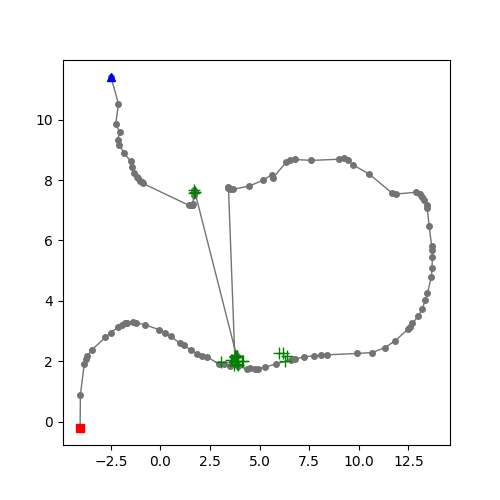

In [101]:
# plot the syllable trajectory and where the nearest neighbors are
ss = embed['syl_id'][i_jump]
print(ss)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[5, 5])
embed_s = embed[embed['syl_id']==ss]
embed_s.index = range(embed_s.shape[0])
x = np.array(embed_s['umap1'])
y = np.array(embed_s['umap2'])
v = embed_s['call_subtype'][0]
ax.plot(x, y,  marker='o', linestyle='-', color='#737373', markersize=4, linewidth=1, alpha=1)
# mark the start with triangle, and end with square
ax.plot(x[0], y[0], marker='^', markersize=6, color='blue', alpha=1)
ax.plot(x[-1], y[-1], marker='s', markersize=6, color='red', alpha=1)

# plot where the nearest neighbors are for the jump point
jump_nn = exact_idx[i_jump,:]
ax.plot(embed['umap1'][jump_nn], embed['umap2'][jump_nn],  marker='+', linestyle='none', color='green', markersize=8, alpha=1)
# save fig
fn_fig =os.path.join(fd_save_run, f'{birdID}.{run_name}.jumpOutlier.pdf')
fig.savefig(fn_fig)

In [91]:
# plot the syllables that these neighbors belong
syl_neighbor = sorted(set(info_comb['syl_id'][jump_nn]))
syl_neighbor

['/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5RigCCU29/Audio/2024-09-11/warble_00060_00002_1_pair5RigCCU29_CU68RigACU53RigBCU29RigC_240911_143116_chan0.wav_17',
 '/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5RigCCU29/Audio/2024-09-11/warble_00060_00003_1_pair5RigCCU29_CU68RigACU53RigBCU29RigC_240911_143116_chan0.wav_35',
 '/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5RigCCU29/Audio/2024-09-11/warble_00060_00010_1_pair5RigCCU29_CU68RigACU53RigBCU29RigC_240911_143116_chan0.wav_5',
 '/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5RigCCU29/Audio/2024-09-12/warble_00025_00004_1_pair5RigCCU29_CU68RigACU53RigBCU29RigC_240912_122606_chan0.wav_31',
 '/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5RigCCU29/Audio/2024-09-12/warble_00025_00005_1_pair5RigCCU29_CU68RigACU53RigBCU29RigC_240912_122606_chan0.wav_19',
 '/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5RigCCU29/Audio/2024-09-12/warble_00025_00007_1_pair5RigCCU29_CU68RigACU53RigBCU29RigC_240912_122606_chan0.wav_24',
 '/mnt/z4/zz367/EphysMO

/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5RigCCU29/Audio/2024-09-12/warble_00028_00009_1_pair5RigCCU29_CU68RigACU53RigBCU29RigC_240912_123106_chan0.wav_16


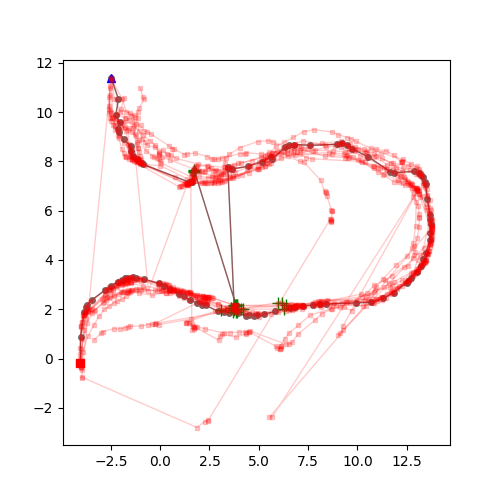

In [114]:
%matplotlib widget
# plot the syllable trajectory and where the nearest neighbors are
ss = embed['syl_id'][i_jump]
print(ss)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[5, 5])
embed_s = embed[embed['syl_id']==ss]
embed_s.index = range(embed_s.shape[0])
x = np.array(embed_s['umap1'])
y = np.array(embed_s['umap2'])
v = embed_s['call_subtype'][0]
ax.plot(x, y,  marker='o', linestyle='-', color='#737373', markersize=4, linewidth=1, alpha=1)
# mark the start with triangle, and end with square
ax.plot(x[0], y[0], marker='^', markersize=6, color='blue', alpha=1)
ax.plot(x[-1], y[-1], marker='s', markersize=6, color='red', alpha=1)

# plot where the nearest neighbors are for the jump point
jump_nn = knn_idx[i_jump,:]
ax.plot(embed['umap1'][jump_nn], embed['umap2'][jump_nn],  marker='+', linestyle='none', color='green', markersize=8, alpha=1)

# plot the syllables that these neighbors belong
syl_neighbor = sorted(set(embed['syl_id'][jump_nn]))
for si in range(0, len(syl_neighbor)):
    ss = syl_neighbor[si]
    embed_s = embed[embed['syl_id']==ss]
    embed_s.index = range(embed_s.shape[0])
    x = np.array(embed_s['umap1'])
    y = np.array(embed_s['umap2'])
    v = embed_s['call_subtype'][0]
    ax.plot(x, y,  marker='s', linestyle='-', color='red', markersize=3, linewidth=1, alpha=0.2)

In [61]:
# examine the distance metrics
from scipy.spatial.distance import pdist, squareform
# Efficient for large datasets
dist_mat = squareform(pdist(latent_comb, metric='euclidean'))
dist_mat.shape

(61152, 61152)

In [64]:
# find the kth neighbors manually
sort_i = np.argsort(dist_mat[i_jump,:])
sort_i[0:nn]

array([ 3808,  3807,  3809,  3806,  1435,  1434,  3810,  3430,  3431,
        3429,  3432,  2596,  2707,  3805,  3119,  2597,  1436,  1645,
       25824,  1646,  3118,  3330,  2170, 38687,  3331])

In [81]:
jump_nn

array([ 3808,  3807,  3809,  3806,  1435,  1434,  3810,  3430,  3431,
        3429,  3432,  2596,  2707,  3805,  3119,  2597,  1436,  1645,
       25824,  1646,  3118,  3330,  2170, 38687,  3331])

#### Examine the VAE latents

(28, 32)


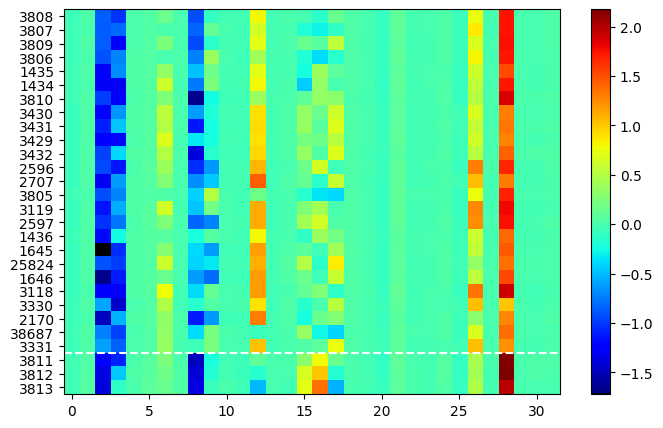

In [87]:
# plot the VAE latents
i_to_check = np.append(jump_nn, [3811, 3812, 3813])
lat = latent_comb[i_to_check, :]
print(lat.shape)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[8, 5])
im=ax.imshow(lat, aspect='auto', cmap=custom_cmap, vmin=np.amin(lat), vmax=np.amax(lat), origin='upper')
ax.set_yticks(range(len(i_to_check)))
ax.set_yticklabels(i_to_check)
ax.axhline(len(jump_nn)-0.5, linestyle='--', color='white')
fig.colorbar(im, ax=ax)

In [88]:
dist_mat[i_jump, i_to_check]

array([0.        , 0.5238735 , 0.53748813, 0.86218771, 1.00770694,
       1.04743382, 1.08596568, 1.0879143 , 1.10946125, 1.1730553 ,
       1.18092924, 1.20508464, 1.20544061, 1.2111725 , 1.2754553 ,
       1.28027798, 1.28295673, 1.28864539, 1.29888191, 1.31803862,
       1.31865541, 1.32013178, 1.34306125, 1.34470427, 1.346375  ,
       1.48996276, 1.9965772 , 2.53468066])

#### Examine the raw and recontructed spectrogram windows

In [141]:
# load the VAE model
fn_vae = os.path.join(fd_vae, f'{birdID}_checkpoint_final.tar')
model = vae_goffinet.VAE(save_dir=fd_vae)
model.load_state(fn_vae)

In [119]:
fd_spec = os.path.join(fd_data, birdID, 'Traj', spec_suffix)
fn_spec = os.path.join(fd_spec, f'{birdID}.{spec_run}.h5')
fn_info_spec = os.path.join(fd_spec, f'{birdID}.{spec_run}.info.csv')
info_spec = pd.read_csv(fn_info_spec, index_col=0)
# add a syllable id column
info_spec['syl_id'] = [f'{info_spec["fn_wav"][ii]}_{info_spec["s_idx"][ii]}' for ii in info_spec.index]
info_spec.shape

(84254, 13)

In [152]:
# loop through neighbors, find the 
spec_syl_all = []
spec_raw_all = []
for ii in i_to_check:
    # ii = i_to_check[0]
    syl_this = embed['syl_id'][ii]
    # locate the syllable index in the master h5 file
    syl_i = info_spec[info_spec['syl_id']==syl_this].index[0]
    # read the spectrogram
    with h5py.File(fn_spec, "r") as f:
        spec_syl = f[f'spec_{syl_i}'][:]
        
    spec_syl_all.append(spec_syl)
    # find the spectrogram window
    spec_raw = spec_syl[:, embed['i_s'][ii]:embed['i_e'][ii]]
    # resize to 128*128
    spec_raw = transform.resize(spec_raw, (128, 128), order=1, mode='edge', anti_aliasing=True)
    
    spec_raw_all.append(spec_raw)

In [153]:
# convert to datasets
spec_raw_all = np.stack(spec_raw_all,  axis=0)
X_tensor = torch.from_numpy(spec_raw_all).float()
dataset = TensorDataset(X_tensor)
# Create DataLoader
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)  

# loop through dataloader, obtain model latent space
latent_m = np.zeros((spec_raw_all.shape[0], 32))
latent_d = np.zeros((spec_raw_all.shape[0], 32))
spec_recon_all = np.zeros((spec_raw_all.shape[0], 128, 128))
model.eval()
count = 0
for i, data in tqdm.tqdm(enumerate(train_dataloader)):
    data = data[0].to('cuda:0')
    with torch.no_grad():
        _, _, rec, mu, d = model.forwardZZ(data, return_latent_rec=True)
        a = mu.shape[0]
        latent_m[count:(count+a),:] = mu
        latent_d[count:(count+a),:] = d
        spec_recon_all[count:(count+a),:,:] = rec
        count += a

1it [00:00,  1.39it/s]


In [154]:
print(spec_raw_all.shape, spec_recon_all.shape)

(28, 128, 128) (28, 128, 128)


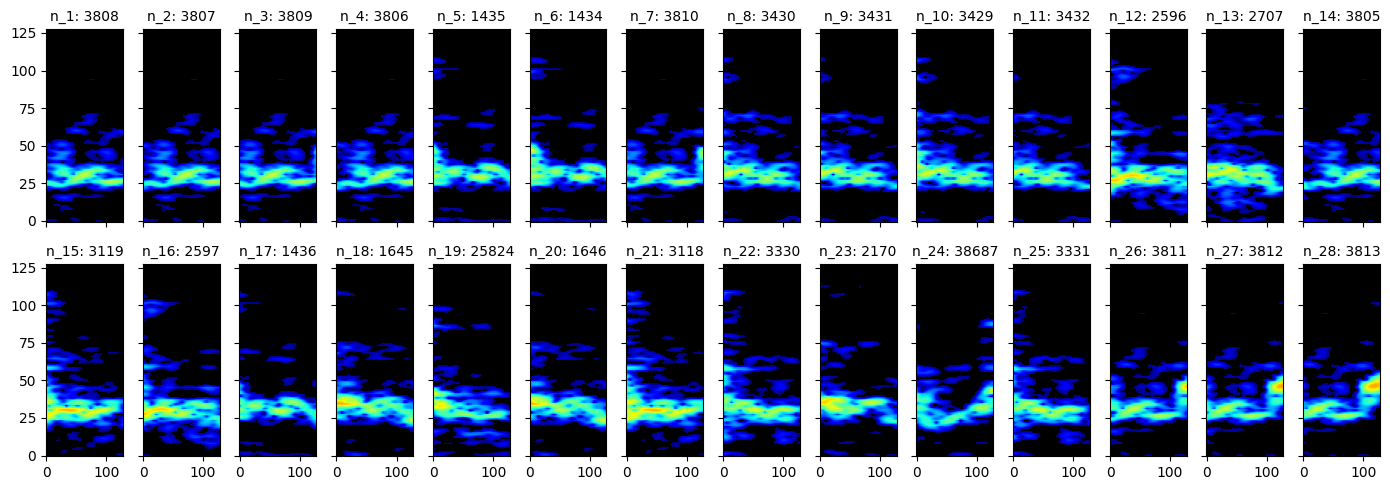

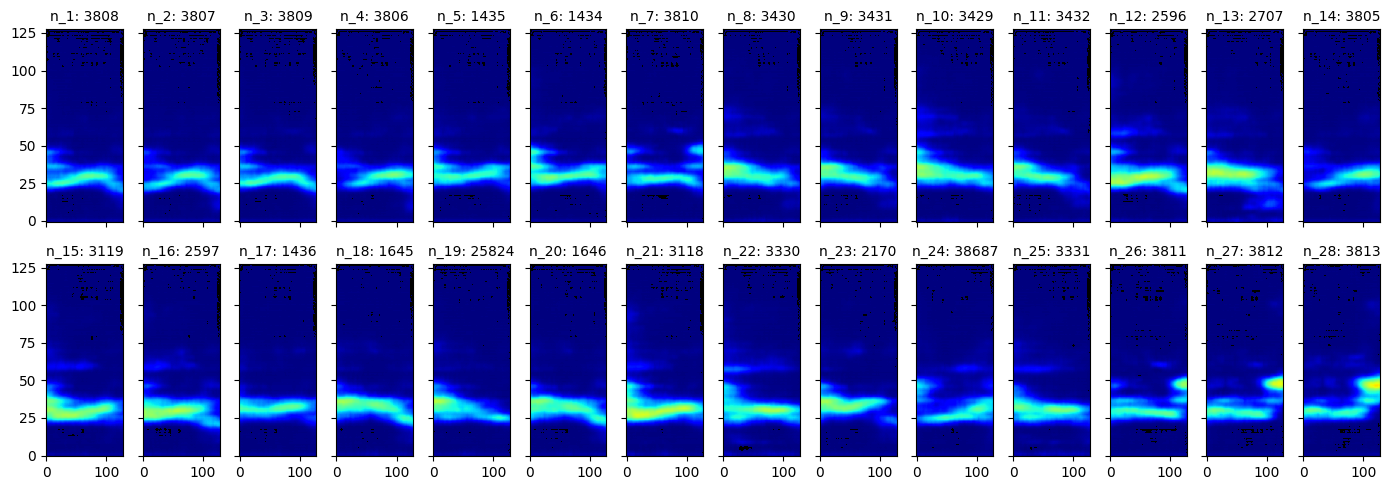

In [169]:
%matplotlib inline
## plot raw and reconstructed spectrogram
d_plot = [spec_raw_all, spec_recon_all]
for di in range(len(d_plot)):
    d = d_plot[di]
    fig, axes = plt.subplots(nrows=2, ncols=14, figsize=[14, 5], sharex=True, sharey=True)
    for ii in range(d.shape[0]):
        plot_i = ii // 14
        plot_j = ii % 14
        ax = axes[plot_i][plot_j]
        ax.imshow(d[ii,:,:], aspect='auto', cmap=custom_cmap, vmin=0, vmax=1, origin='lower')
        ax.set_title(f'n_{ii+1}: {i_to_check[ii]}', fontsize=10)
    plt.tight_layout()